In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'data-science-day1-titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1247358%2F2080558%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240712%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240712T161652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D14e9dbc5d3f33c1ec1b73c4326cc6d56de4c3f29c927487aaa3a19cf1f120663457e4f06d38ec125e5ccbee9d543ef0dd7f9a0abc66f741d87624654c8871df1717f18f34f4868f08be20f2bf73a9230959ace55cffad2f29bcd13365a20bff4f4fe73a9b5da823476324f23495fc7859285df1d9edad279b83fdab74b80bcd6711d7a82f80fdd98f673cc3daa5dfa197c77526e287743573a042aed94ca3e6ede8193692180f94c61018a30768219d9b3ae074b88f055eacef2486d72a8653e28fa8669d6110abadfab7fa872e7715031f673deb2cfb3fad7f8dbde56e3e6ba34bb4c0085d21e9f3f6b2422b38ec1217f2063bf4cd5fdc77abef8d481db08b9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 22578 bytes downloaded
Downloaded and uncompressed: data-science-day1-titanic
Data source import complete.


# Titanic End-to-End Feature Engineering and Data Preprocessing Exercise

- **In this application, using the Titanic dataset, we will clean the data and convert it into the format required by the machine learning model by applying the following steps in order from end to end.**

# Road Map

1. **Import Required Libraries**

2. **Adjusting Row Column Settings**

3. **Loading the data set.**

4. **Exploratory data analysis.**

5. **Feature Engineering**

6. **Outliers**

7. **Missing Values**

8. **Label Encoding**

9. **Rare Encoding**

10. **One-Hot Encoding**

11. **Standardization**

12. **Bonus :)**

# 1. Import Required Libraries

In [2]:
!pip install missingno

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor  # => çok değişkenli outlier yakalama yöntemi için import edildi.
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

# 2. Adjusting Row Column Settings

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# 3. Loading the data set.

In [5]:
# Loading the Data Set

df = pd.read_csv('/kaggle/input/data-science-day1-titanic/DSB_Day1_Titanic_train.csv')

# 4. Exploratory Data Analysis

In [6]:
# Preliminary examination of the data set

def check_df(dataframe, head=5):
    print('##################### Shape #####################')
    print(dataframe.shape)
    print('##################### Types #####################')
    print(dataframe.dtypes)
    print('##################### Head #####################')
    print(dataframe.head(head))
    print('##################### Tail #####################')
    print(dataframe.tail(head))
    print('##################### NA #####################')
    print(dataframe.isnull().sum())
    print('##################### Quantiles #####################')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(891, 12)
##################### Types #####################
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
##################### Head #####################
   PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch            Ticket   Fare Cabin Embarked
0            1         0       3                            Braund, Mr. Owen Harris    male 22.000      1      0         A/5 21171  7.250   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0          PC 17599 71.283   C85        C
2            3         1       3                             Heikkinen, Miss. Laina  female 

# 5. Feature Engineering

In [7]:
df.columns = [col.upper() for col in df.columns]

In [8]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [9]:
# Cabin Bool

df["New_CABIN_BOOL"] = df["CABIN"].notnull().astype("int")

In [10]:
# Name Count

df["NEW_NAME_COUNT"] = df["NAME"].str.len()

In [11]:
# Name Word Count

df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

In [12]:
# Name Dr

df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

In [13]:
# Name Title

df["NEW_TITLE"] = df.NAME.str.extract(" ([A-Za-z]+)\.", expand=False)

In [14]:
# Family Size

df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

In [15]:
# Age_Pclass

df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [16]:
# IS Alone

df.loc[((df["SIBSP"] + df["PARCH"]) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df["SIBSP"] + df["PARCH"]) == 0), "NEW_IS_ALONE"] = "YES"

In [17]:
# Age Level

df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

In [18]:
# sex x age

df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [19]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,New_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [20]:
# Analysis of Variables.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [21]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 891
Variables: 22
cat_cols: 14
num_cols: 5
cat_but_car: 3
num_but_cat: 8


In [22]:
cat_cols

['SEX',
 'EMBARKED',
 'NEW_TITLE',
 'NEW_IS_ALONE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT',
 'SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'New_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [23]:
num_cols

['PASSENGERID', 'AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [24]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [25]:
cat_but_car

['NAME', 'TICKET', 'CABIN']

In [26]:
num_but_cat

['SURVIVED',
 'PCLASS',
 'SIBSP',
 'PARCH',
 'New_CABIN_BOOL',
 'NEW_NAME_WORD_COUNT',
 'NEW_NAME_DR',
 'NEW_FAMILY_SIZE']

In [27]:
# Categorical Summary Function

def cat_summary(dataframe, col_name, plot=False):
    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

        SEX  Ratio
SEX               
male    577 64.759
female  314 35.241
##########################################


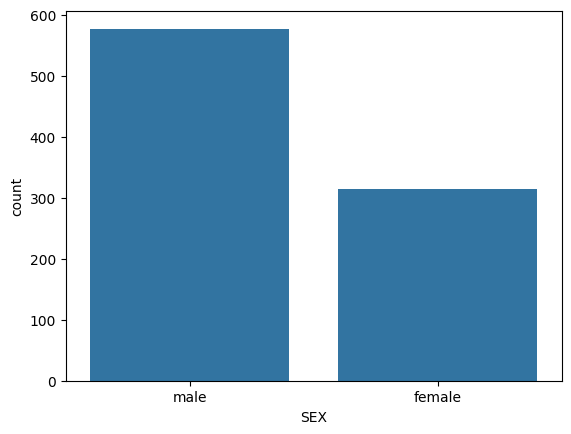

          EMBARKED  Ratio
EMBARKED                 
S              644 72.278
C              168 18.855
Q               77  8.642
##########################################


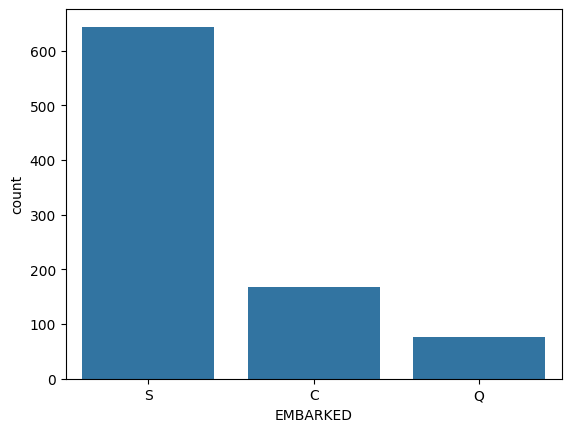

           NEW_TITLE  Ratio
NEW_TITLE                  
Mr               517 58.025
Miss             182 20.426
Mrs              125 14.029
Master            40  4.489
Dr                 7  0.786
Rev                6  0.673
Mlle               2  0.224
Major              2  0.224
Col                2  0.224
Countess           1  0.112
Capt               1  0.112
Ms                 1  0.112
Sir                1  0.112
Lady               1  0.112
Mme                1  0.112
Don                1  0.112
Jonkheer           1  0.112
##########################################


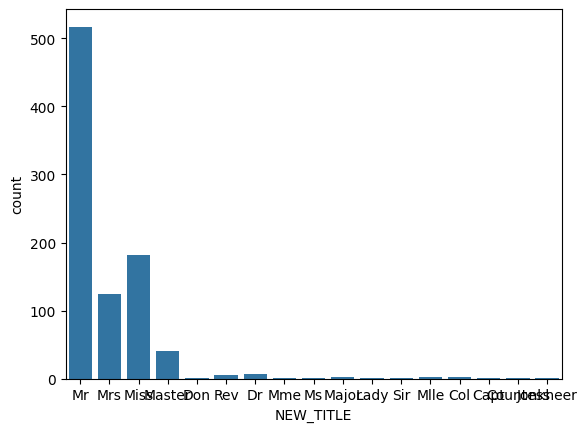

              NEW_IS_ALONE  Ratio
NEW_IS_ALONE                     
YES                    537 60.269
NO                     354 39.731
##########################################


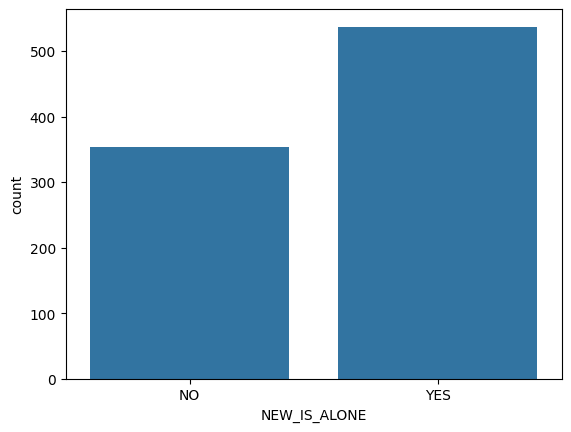

             NEW_AGE_CAT  Ratio
NEW_AGE_CAT                    
mature               562 63.075
young                113 12.682
senior                39  4.377
##########################################


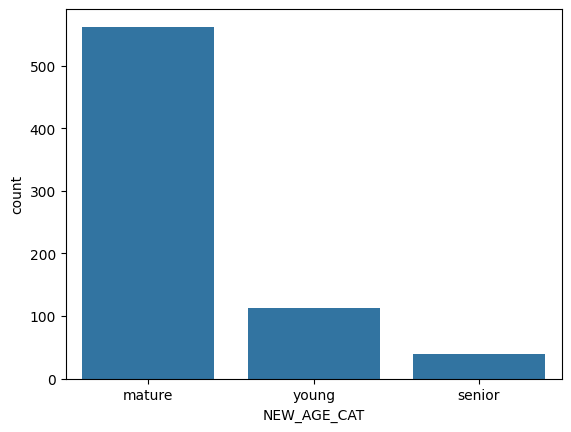

              NEW_SEX_CAT  Ratio
NEW_SEX_CAT                     
maturemale            530 59.484
maturefemale          297 33.333
seniormale             47  5.275
seniorfemale           17  1.908
##########################################


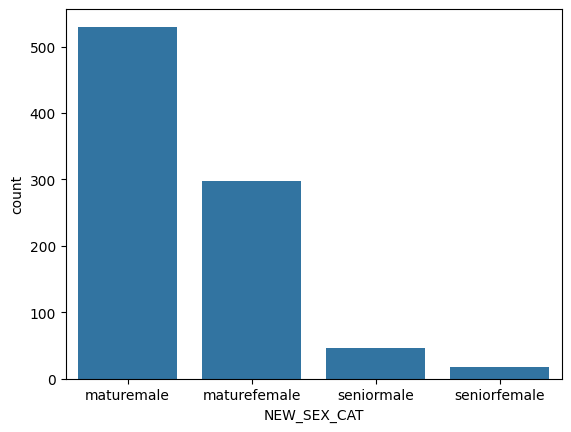

          SURVIVED  Ratio
SURVIVED                 
0              549 61.616
1              342 38.384
##########################################


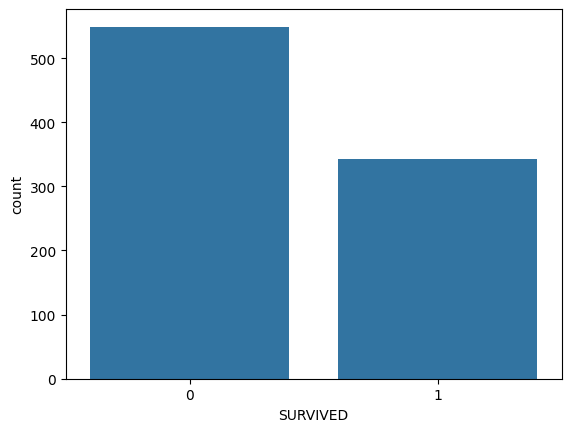

        PCLASS  Ratio
PCLASS               
3          491 55.107
1          216 24.242
2          184 20.651
##########################################


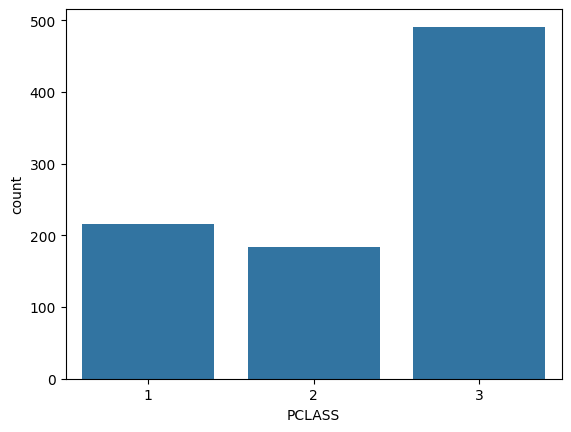

       SIBSP  Ratio
SIBSP              
0        608 68.238
1        209 23.457
2         28  3.143
4         18  2.020
3         16  1.796
8          7  0.786
5          5  0.561
##########################################


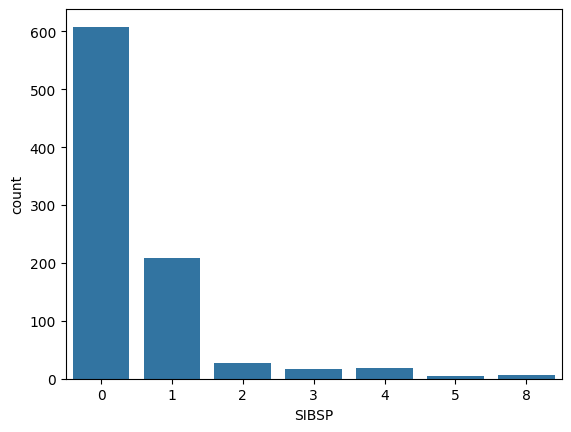

       PARCH  Ratio
PARCH              
0        678 76.094
1        118 13.244
2         80  8.979
5          5  0.561
3          5  0.561
4          4  0.449
6          1  0.112
##########################################


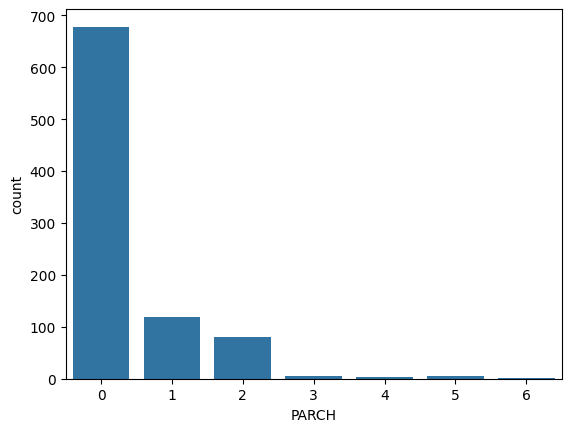

                New_CABIN_BOOL  Ratio
New_CABIN_BOOL                       
0                          687 77.104
1                          204 22.896
##########################################


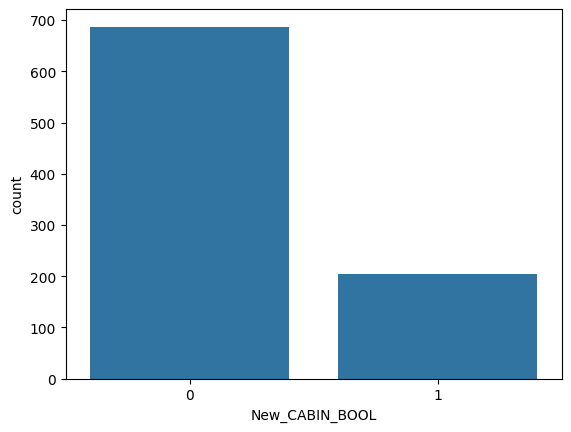

                     NEW_NAME_WORD_COUNT  Ratio
NEW_NAME_WORD_COUNT                            
4                                    388 43.547
3                                    305 34.231
5                                     96 10.774
6                                     53  5.948
7                                     38  4.265
8                                      9  1.010
14                                     1  0.112
9                                      1  0.112
##########################################


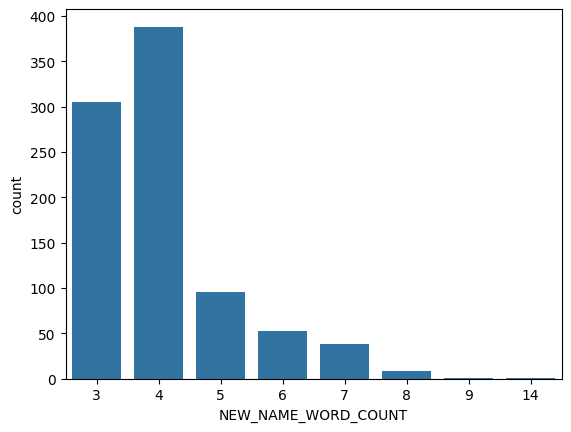

             NEW_NAME_DR  Ratio
NEW_NAME_DR                    
0                    881 98.878
1                     10  1.122
##########################################


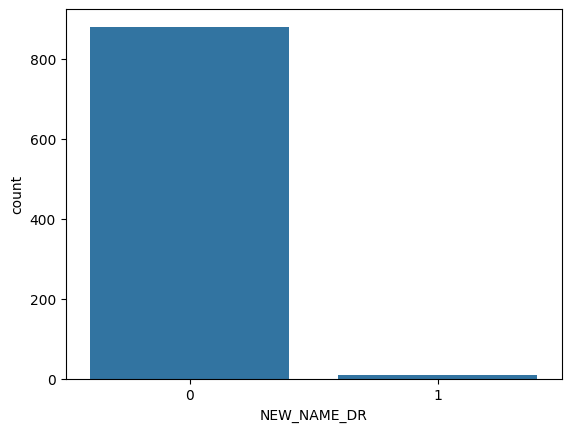

                 NEW_FAMILY_SIZE  Ratio
NEW_FAMILY_SIZE                        
1                            537 60.269
2                            161 18.070
3                            102 11.448
4                             29  3.255
6                             22  2.469
5                             15  1.684
7                             12  1.347
11                             7  0.786
8                              6  0.673
##########################################


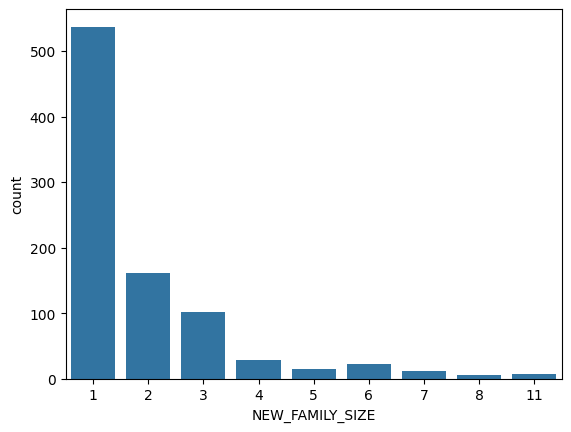

In [28]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [29]:
# Numerical Summary Function

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count   714.000
mean     29.699
std      14.526
min       0.420
5%        4.000
10%      14.000
20%      19.000
30%      22.000
40%      25.000
50%      28.000
60%      31.800
70%      36.000
80%      41.000
90%      50.000
95%      56.000
99%      65.870
max      80.000
Name: AGE, dtype: float64


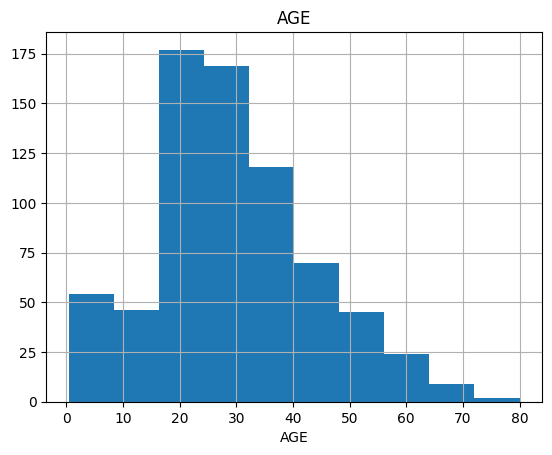

count   891.000
mean     32.204
std      49.693
min       0.000
5%        7.225
10%       7.550
20%       7.854
30%       8.050
40%      10.500
50%      14.454
60%      21.679
70%      27.000
80%      39.688
90%      77.958
95%     112.079
99%     249.006
max     512.329
Name: FARE, dtype: float64


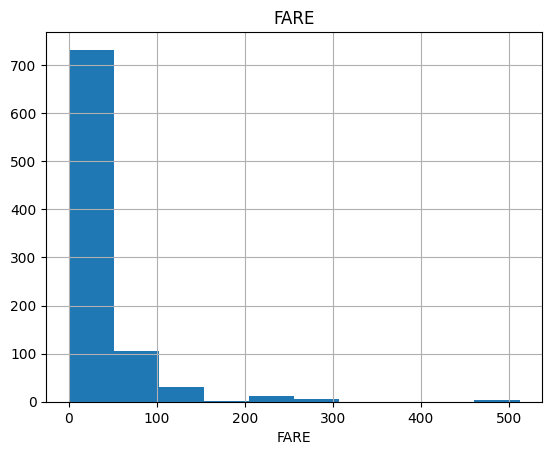

count   891.000
mean     26.965
std       9.282
min      12.000
5%       16.000
10%      17.000
20%      19.000
30%      21.000
40%      23.000
50%      25.000
60%      27.000
70%      29.000
80%      32.000
90%      41.000
95%      47.000
99%      55.100
max      82.000
Name: NEW_NAME_COUNT, dtype: float64


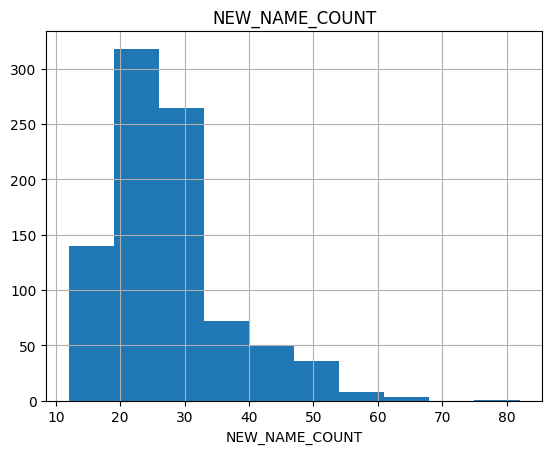

count   714.000
mean     61.938
std      34.380
min       0.920
5%       12.000
10%      21.000
20%      34.600
30%      44.900
40%      51.000
50%      58.000
60%      65.000
70%      75.000
80%      87.000
90%     108.000
95%     124.700
99%     153.000
max     222.000
Name: NEW_AGE_PCLASS, dtype: float64


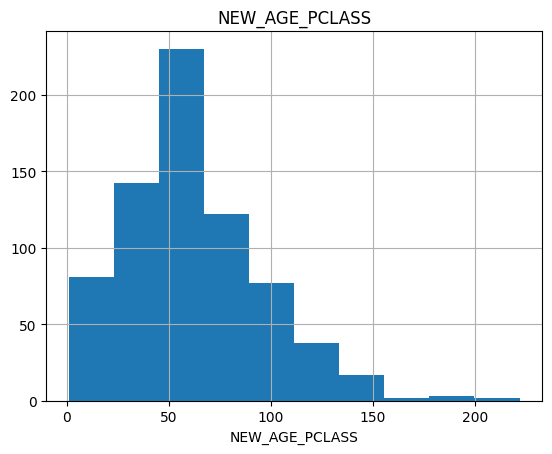

In [30]:
for col in num_cols:
    num_summary(df, col, plot=True)

# 6. Outliers

In [31]:
# Outlier Threshold Calculation Function

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [32]:
# Outlier Check Function

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [33]:
# Replace Outliers with Thresholds

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [34]:
# Visualizing Outliers in a Boxplot

def boxplot_outliers(dataframe, col_name):
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=dataframe[col_name])
    plt.show(block=True)

In [35]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE True
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


In [36]:
for col in num_cols:
    print(col, replace_with_thresholds(df, col))

AGE None
FARE None
NEW_NAME_COUNT None
NEW_AGE_PCLASS None


In [37]:
for col in num_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


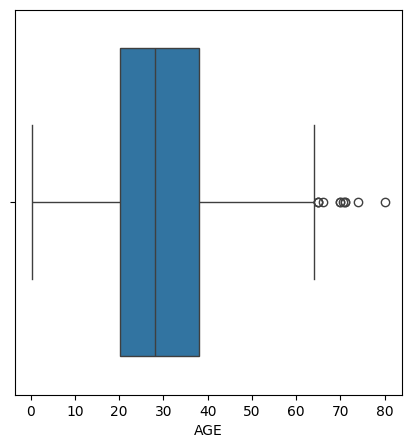

AGE None


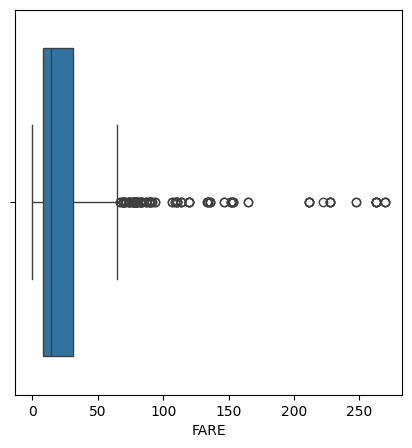

FARE None


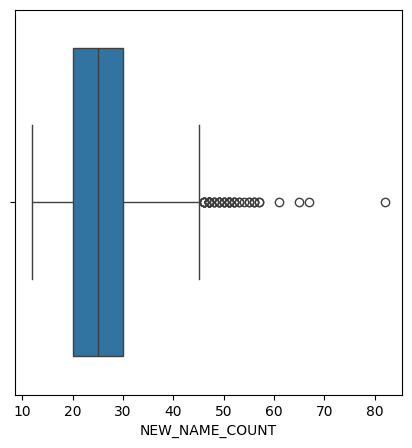

NEW_NAME_COUNT None


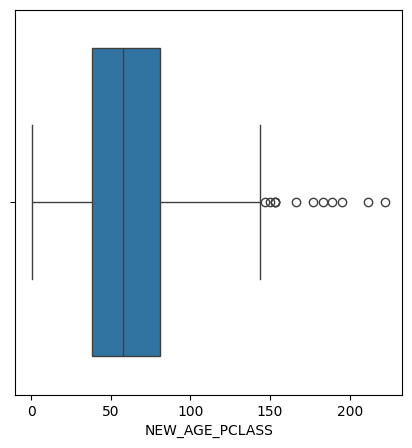

NEW_AGE_PCLASS None


In [38]:
for col in num_cols:
    print(col, boxplot_outliers(df, col))

# 7. Missing Values

In [39]:
# Analyzing Missing Values in a DataFrame

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')

    if na_name:
        return na_columns

In [40]:
missing_values_table(df, na_name=False)

                n_miss  ratio
CABIN              687 77.100
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [41]:
df.drop("CABIN", inplace=True, axis=1)

In [42]:
missing_values_table(df, na_name=False)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [43]:
remove_cols = ["TICKET", "NAME"]

In [44]:
df.drop(remove_cols, inplace=True, axis=1)

In [45]:
missing_values_table(df, na_name=False)

                n_miss  ratio
AGE                177 19.870
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [46]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [47]:
missing_values_table(df, na_name=False)

                n_miss  ratio
NEW_AGE_PCLASS     177 19.870
NEW_AGE_CAT        177 19.870
EMBARKED             2  0.220


In [48]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [49]:
df.loc[(df["AGE"] < 18), "NEW_AGE_CAT"] = "young"
df.loc[(df["AGE"] >= 18) & (df["AGE"] < 56), "NEW_AGE_CAT"] = "mature"
df.loc[(df["AGE"] >= 56), "NEW_AGE_CAT"] = "senior"

In [50]:
df.loc[(df["SEX"] == "male") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngmale"
df.loc[(df["SEX"] == "male") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturemale"
df.loc[(df["SEX"] == "male") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniormale"
df.loc[(df["SEX"] == "female") & (df["AGE"] <= 21), "NEW_SEX_CAT"] = "youngfemale"
df.loc[(df["SEX"] == "female") & ((df["AGE"] > 21) & (df["AGE"]) <= 50), "NEW_SEX_CAT"] = "maturefemale"
df.loc[(df["SEX"] == "female") & (df["AGE"] > 50), "NEW_SEX_CAT"] = "seniorfemale"

In [51]:
missing_values_table(df, na_name=False)

          n_miss  ratio
EMBARKED       2  0.220


In [52]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [53]:
missing_values_table(df, na_name=False)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


# 8. Label Encoding

In [54]:
# Label Encoding Function

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [55]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]

In [56]:
for col in binary_cols:
    df = label_encoder(df, col)

In [57]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,SEX,AGE,SIBSP,PARCH,FARE,EMBARKED,New_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,1,22.000,1,0,7.250,S,0,23.000,4,0,Mr,2,66.000,0,mature,maturemale
1,2,1,1,0,38.000,1,0,71.283,C,1,51.000,7,0,Mrs,2,38.000,0,mature,maturefemale
2,3,1,3,0,26.000,0,0,7.925,S,0,22.000,3,0,Miss,1,78.000,1,mature,maturefemale
3,4,1,1,0,35.000,1,0,53.100,S,1,44.000,7,0,Mrs,2,35.000,0,mature,maturefemale
4,5,0,3,1,35.000,0,0,8.050,S,0,24.000,4,0,Mr,1,105.000,1,mature,maturemale


# 9. Rare Encoding

In [58]:
# Rare Category Analysis Function

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [59]:
rare_analyser(df, "SURVIVED", cat_cols)

SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


EMBARKED : 3
          COUNT  RATIO  TARGET_MEAN
EMBARKED                           
C           168  0.189        0.554
Q            77  0.086        0.390
S           646  0.725        0.339


NEW_TITLE : 17
           COUNT  RATIO  TARGET_MEAN
NEW_TITLE                           
Capt           1  0.001        0.000
Col            2  0.002        0.500
Countess       1  0.001        1.000
Don            1  0.001        0.000
Dr             7  0.008        0.429
Jonkheer       1  0.001        0.000
Lady           1  0.001        1.000
Major          2  0.002        0.500
Master        40  0.045        0.575
Miss         182  0.204        0.698
Mlle           2  0.002        1.000
Mme            1  0.001        1.000
Mr           517  0.580        0.157
Mrs          125  0.140        0.792
Ms             1  0.001        1.000
Rev            6  0.007    

In [60]:
# Rare Encoder Function

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [61]:
df = rare_encoder(df, 0.01)

In [62]:
df["NEW_TITLE"].value_counts()

NEW_TITLE
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64

# 10. One-Hot Encoding

In [63]:
# One-Hot Encoder Funtion

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [64]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]

In [65]:
df = one_hot_encoder(df, ohe_cols)

In [66]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,New_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale
0,1,0,1,22.000,7.250,0,23.000,0,66.000,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1,2,1,0,38.000,71.283,1,51.000,0,38.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,0,26.000,7.925,0,22.000,0,78.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,35.000,53.100,1,44.000,0,35.000,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,1,35.000,8.050,0,24.000,0,105.000,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [67]:
df.shape

(891, 50)

In [68]:
# Analysis of Variables.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.
    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri
    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi
    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))
    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f'Observations: {dataframe.shape[0]}')
    print(f'Variables: {dataframe.shape[1]}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [69]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(df)

Observations: 891
Variables: 50
cat_cols: 45
num_cols: 5
cat_but_car: 0
num_but_cat: 45


In [70]:
num_cols = [col for col in num_cols if "PASSENGERID" not in col]

In [71]:
num_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [72]:
rare_analyser(df, "SURVIVED", cat_cols)

SURVIVED : 2
          COUNT  RATIO  TARGET_MEAN
SURVIVED                           
0           549  0.616        0.000
1           342  0.384        1.000


SEX : 2
     COUNT  RATIO  TARGET_MEAN
SEX                           
0      314  0.352        0.742
1      577  0.648        0.189


New_CABIN_BOOL : 2
                COUNT  RATIO  TARGET_MEAN
New_CABIN_BOOL                           
0                 687  0.771        0.300
1                 204  0.229        0.667


NEW_NAME_DR : 2
             COUNT  RATIO  TARGET_MEAN
NEW_NAME_DR                           
0              881  0.989        0.383
1               10  0.011        0.500


NEW_IS_ALONE : 2
              COUNT  RATIO  TARGET_MEAN
NEW_IS_ALONE                           
0               354  0.397        0.506
1               537  0.603        0.304


PCLASS_2 : 2
          COUNT  RATIO  TARGET_MEAN
PCLASS_2                           
False       707  0.793        0.361
True        184  0.207        0.473


PCLASS

In [73]:
uselses_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

In [74]:
# if we want to drop this list "uselses_cols" we use this cod "df.drop(useless_cols,axis=1, inplace=True)"

# 11. Standardization

In [75]:
scaler = StandardScaler()

In [76]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [77]:
df[num_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.557,-0.557,-0.427,0.063
1,0.649,0.920,2.591,-0.787
2,-0.256,-0.541,-0.535,0.427
3,0.423,0.501,1.836,-0.878
4,0.423,-0.538,-0.320,1.247


In [78]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,New_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_2,PCLASS_3,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale
0,1,0,1,-0.557,-0.557,0,-0.427,0,0.063,0,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1,2,1,0,0.649,0.920,1,2.591,0,-0.787,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,3,1,0,-0.256,-0.541,0,-0.535,0,0.427,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,4,1,0,0.423,0.501,1,1.836,0,-0.878,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5,0,1,0.423,-0.538,0,-0.320,0,1.247,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


# 12. Model

In [79]:
# Dependent variable

y = df["SURVIVED"]

In [80]:
# Independent variables

X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

In [81]:
# Train-Test Split for Machine Learning Model Evaluation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [82]:
# Random Forest Classifier Model Training

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [83]:
# Prediction using Random Forest Classifier Model

y_pred = rf_model.predict(X_test)

In [84]:
# Accuracy Score of Random Forest Classifier Model Prediction

accuracy_score(y_pred, y_test)

0.7985074626865671

**If people had given us their information before they boarded the ship, and we had used this information to ask the model, we could have accurately predicted whether 79% of those who boarded the ship would have survived.**

In [85]:
# Plot Importance

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

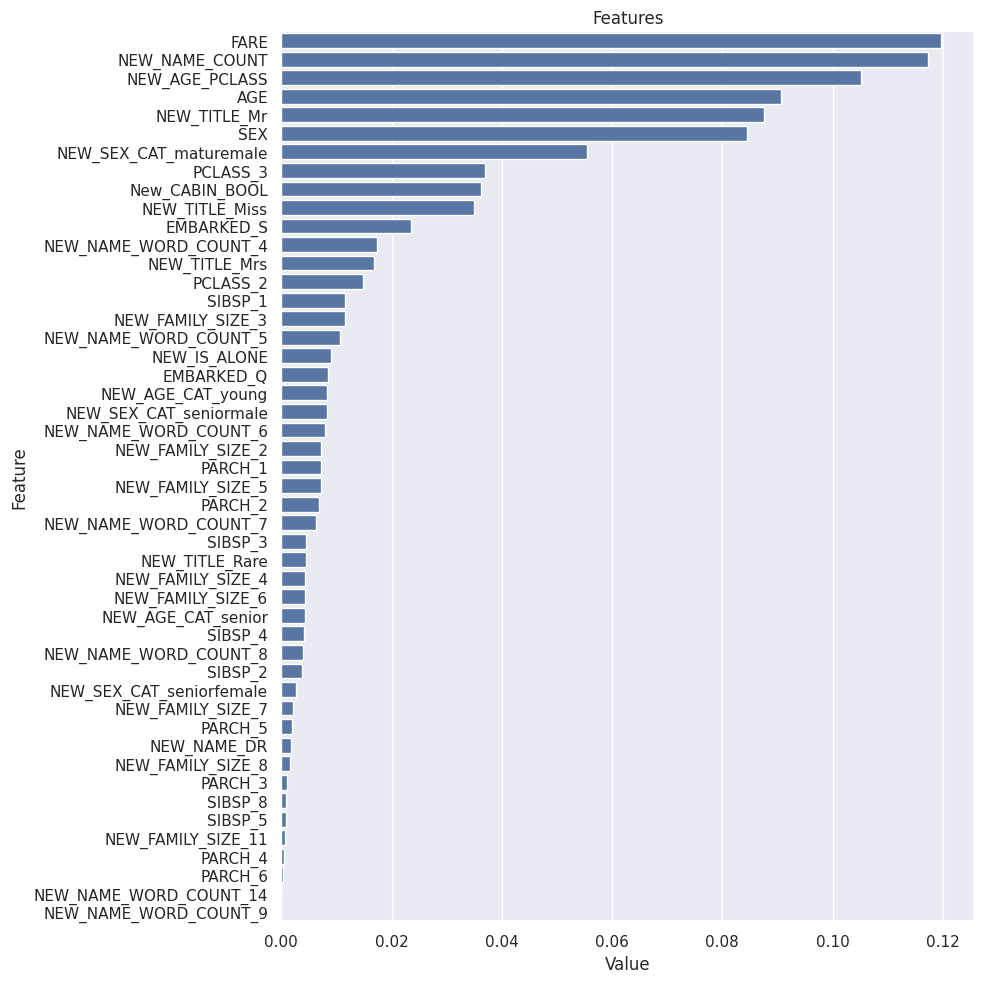

In [86]:
plot_importance(rf_model, X_train)

# 13. Accuracy Score without Performing Any Operation

In [87]:
# Loading the Data Set

dff = pd.read_csv('/kaggle/input/data-science-day1-titanic/DSB_Day1_Titanic_train.csv')

In [88]:
dff.dropna(inplace=True)

In [89]:
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True)

In [90]:
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [92]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

In [93]:
y_pred = rf_model.predict(X_test)

In [94]:
accuracy_score(y_pred, y_test)

0.7090909090909091

# 14. Plot Importance

In [95]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

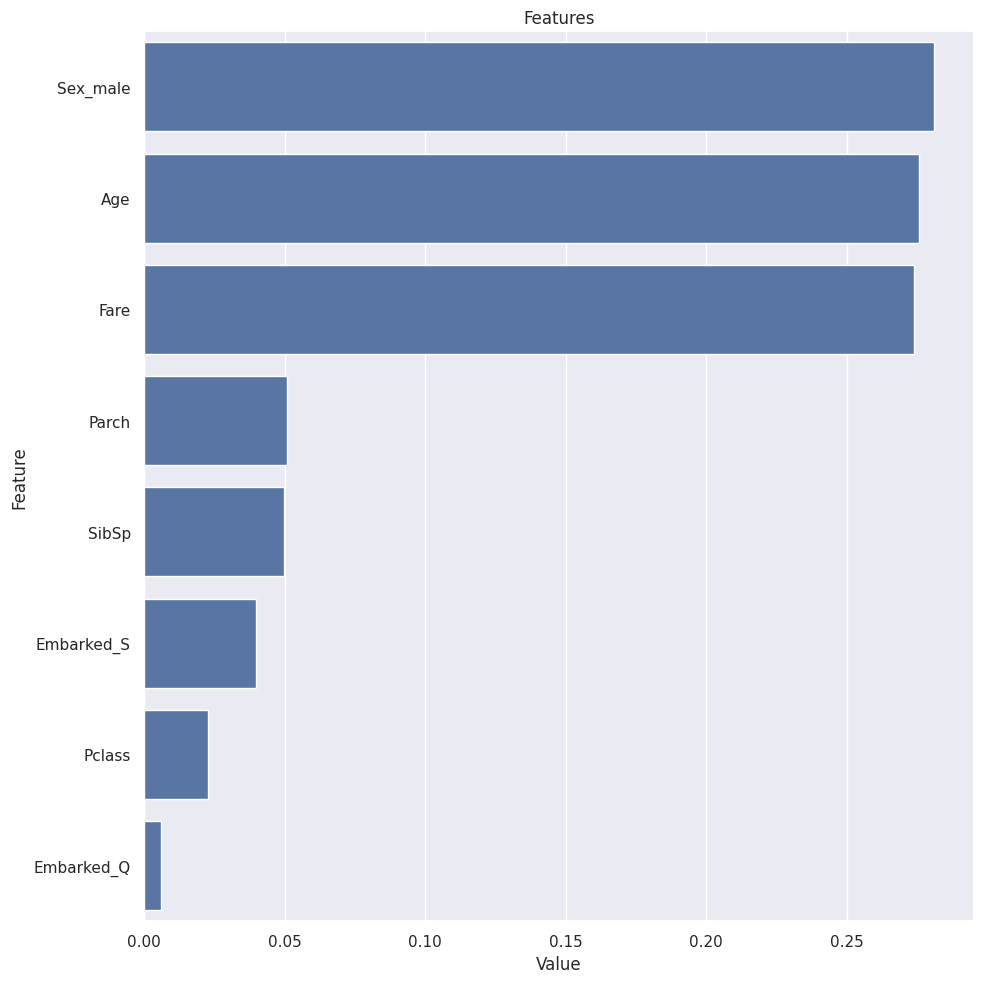

In [96]:
plot_importance(rf_model, X_train)